# Dimensionality Reduction and Clustering Tests

**Data Science with AIML**<br>
MITES Summer 2025<br>
2025-07-16

My attempts at **dimensionality reduction**, and **clustering** of the OpenPayments Medical Data with HDBSCAN and Keppler Mapper 

These are the Python imports we're using:

In [13]:
from pathlib import Path
import time
from statistics import median_high as median
import warnings
import random
warnings.simplefilter(action="ignore", category=(UserWarning, FutureWarning))
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer



In [2]:
def remove_nan(PATH_TO_FILE):
    df = pd.read_csv(PATH_TO_FILE, low_memory = False)

    pd.reset_option('display.max_rows')
    pd.options.display.max_columns = None

    #Counts the number of Nans under each column and displays it in a list
    counts_list = []
    for name, current_column in df.items():
        count = 0
        for value in current_column:
            if type(value) is float:
                if math.isnan(value):
                    count += 1
        counts_list.append(count)

        
    #Take the list of number of Nans for each columns
    #And convert that list to a list of percentages of how much of each column  is NaN
    percentages_list=[]
    for current_count in counts_list:
        percentages_list.append(current_count / len(df) * 100)
        
    #Format those percentages to remove extraneous decimal points
    formatted_percentage_list = ["{:.1f}".format(percentage) for percentage in percentages_list]

    #Find out which columns must be removed, and make a cleaned data frame 
    list_of_column_names = []
    for index, percentage in enumerate(formatted_percentage_list):
        if float(percentage) > 80.0: #Percentage Threshold of whether the column should be deleted
            list_of_column_names.append(df.columns[index])

    cleaned_df = df.copy()
    cleaned_df.drop(columns=list_of_column_names, inplace=True)



    # print (len(df.columns))
    # print (len(cleaned_df.columns))
    # print("\n \n ------------------Headers in cleaned data set------------------ \n ")
    # print(list(cleaned_df.columns))

    return cleaned_df


PATH_TO_FILE = "C:/Users/mjkuo/Documents/MITES_Summer_ML/MLFP/2024HealthcareFiles/OP_DTL_RSRCH_PGYR2024_P06302025_06162025.csv"
cleaned_df = remove_nan(PATH_TO_FILE)

## Dimensionality reduction

OK but 300+ dimensions is too much.... Let's tone this down to 2 dimensions and then plot it.

In [14]:
reducer = umap.UMAP(random_state=23, n_components=12)

In [ ]:
# reduced_embeddings = reducer.fit_transform(cleaned_df)

# print(reduced_embeddings.shape)
# reduced_embeddings

ValueError: could not convert string to float: 'ADD'

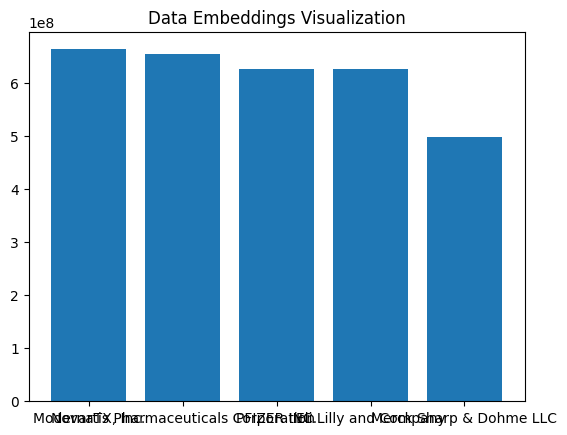

['ModernaTX, Inc.', 'Novartis Pharmaceuticals Corporation', 'PFIZER INC.', 'Eli Lilly and Company', 'Merck Sharp & Dohme LLC']
662825759.6799968
654310301.6199994
626184002.4200023
626090349.8600003
497541871.4700009


In [49]:
plot_title = "Data Embeddings Visualization"

companies = cleaned_df["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"]
money = cleaned_df["Total_Amount_of_Payment_USDollars"]

company_spending = {}
for i in range(len(companies)):
    if companies[i] not in company_spending:
        company_spending[companies[i]] = 0
    company_spending[companies[i]] += money[i]

sorted_money = sorted(company_spending, 
                          key=lambda co: company_spending[co], 
                          reverse=True)

sorted_spending = {
    co: company_spending[co] for co in sorted_money
}

number = 5
plt.bar([i for i in range(number)], list(sorted_spending.values())[:number], tick_label=list(sorted_spending.keys())[:number])
plt.title(plot_title)
plt.show()

print(sorted_money[:number])
for i in sorted_money[:number]:
    print(sorted_spending[i])

In [26]:
df = pd.read_csv('../2024HealthcareFiles/OP_DTL_RSRCH_PGYR2024_P06302025_06162025.csv', low_memory=False)



Does this shape look interesting?

## Clustering

Chance are, there's *some* shape to your data, but what are those data points? We can use clustering methods to cluster the data into meaningful groups, and then we'll plot again with some color.

In [ ]:
clusterer = hdbscan.HDBSCAN()

In [ ]:
clusterer.fit(reduced_embeddings)

labels = [int(i) for i in sorted(set(clusterer.labels_))]

print(labels)

Let's try plotting again, this time coloring the dots by the cluster.

In [ ]:
plt.scatter(x, y, c=clusterer.labels_)
plt.title(plot_title)
plt.show()

Cool! But now what even are these clusters about? Remember, each dot represents **one sentence** from your text corpus. Let's randomly sample a few from each cluster to see what they're about.

In [ ]:
# organize clusters into list
clusters = []
for label in labels:
    mask = clusterer.labels_ == label
    clusters.append(sentences[mask])

In [ ]:
# randomly sample k sentences from each cluster
# (note: same sentence might appear more than once
# for small clusters)
k = 5

for i, cluster in enumerate(clusters):
    print(f"Cluster {i}:")
    random_sentences = random.choices(cluster, k=k)
    for sentence in random_sentences:
        print(f"- {sentence}")
    print()

print(clusters[0])

## Naming the clusters



In [ ]:
def clean(text):
    """Standardize the text

    Make lowercase, separate punctuation, fix spacing.

    Args:
        text (str): The text to standardize

    Returns:
        str: The cleaned up text
    """
    text = text.lower()
    text = text.replace("\n", " ")
    text = text.replace("!", "  ")
    text = text.replace("?", "  ")
    text = text.replace(". ", "  ")
    text = text.replace(",", "  ")
    text = text.replace('''"''', '''  ''') # Min-Jae added this
    text = text.replace("(", "  ") # Min-Jae added this
    text = text.replace(")", "  ") # Min-Jae added this
    text = text.replace(" ", "  ") # Min-Jae added this

    while "  " in text:
        text = text.replace("  ", " ")

    return text

def tokenize(text):
    """Clean & tokenize the text

    Args:
        text (str): The text to tokenize

    Returns:
        list[str]: The tokenized text, as a list of str
    """
    text = clean(text)
    tokens = text.split(" ")
    if tokens[-1] == "":
        tokens = tokens[:-1]
    if tokens[0] == "":
        tokens.pop(0)
    return tokens

stop_words = ["the", "and", "is", "are", "of", "in", "a", "to", "as", "or", "such", "for", "at", "was", "that", "their", "can", "with"]

def remove_stop_words(word_list):
    for stop_word in stop_words:
        while stop_word in word_list:
            word_list.remove(stop_word)
    return word_list

In [ ]:
# find most common words in each cluster
for i, cluster in enumerate(clusters):
    word_counter = {}
    
    for sentence in cluster:
        cleaned = clean(sentence)
        tokens = tokenize(cleaned)
        unstopped_tokens = remove_stop_words(tokens)
        
        for word in unstopped_tokens:
            if word not in word_counter:
                word_counter[word] = 0
            word_counter[word] += 1
            
    sorted_words = sorted(word_counter, key=lambda word: word_counter[word], reverse=True)
    word_counter = {word: word_counter[word] for word in sorted_words}
    word_df = pd.DataFrame({"Word": word_counter.keys(), "Frequency": word_counter.values()})
    print(f"Cluster {i} Name:")
    print(*word_df.head(3)["Word"].values)
    print()
    